# Customer Segmentation — Mall Customers
**Project description:** This notebook performs customer segmentation on the *Mall Customer* dataset. We'll clean and explore the data, select features (Annual Income & Spending Score), scale them, determine an optimal number of clusters (Elbow method & Silhouette score), train a K‑Means model, visualize clusters, and compare with other clustering algorithms (DBSCAN & Agglomerative). A 3D visualization (Income, Spending Score, Age) is included as a bonus.


## Table of contents
1. Import Libraries
2. Load Dataset
3. Data Cleaning
4. Exploratory Data Analysis (EDA)
5. Feature Selection & Scaling
6. Determine Optimal Number of Clusters
7. K-Means Clustering
8. Visualization (2D)
9. Evaluation & Analysis
10. Bonus: Other Algorithms (DBSCAN / Agglomerative) & 3D Visualization
11. Conclusion

---


## 1) Import Libraries
Import required libraries. This cell also sets plotting styles for the notebook.


In [1]:
# Data manipulation & utils
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine learning & clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

# Optional interactive 3D visualization
# (Plotly is optional; uncomment the pip install line if Colab doesn't have it)
# !pip install -q plotly
import plotly.express as px

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print('Libraries imported successfully')

Libraries imported successfully


## 2) Load Dataset
There are multiple ways to load the dataset in Colab:
- Upload the CSV directly (recommended)
- Use Kaggle API (requires setting up `kaggle.json`)
- Provide a Google Drive / GitHub link

Use the option that fits your setup. The cell below includes an automatic path fallback; update `csv_path` if needed.

In [2]:
# Option A (Colab): upload the file manually with files.upload()
# from google.colab import files
# uploaded = files.upload()  # then set csv_path = 'Mall_Customers.csv' or the uploaded filename

# Option B (Kaggle): use Kaggle API after uploading kaggle.json (commented out)
# !pip install -q kaggle
# import json, os
# os.makedirs('/root/.kaggle', exist_ok=True)
# with open('/root/.kaggle/kaggle.json','w') as f:
#     f.write(open('kaggle.json').read())
# os.chmod('/root/.kaggle/kaggle.json', 0o600)
# !kaggle datasets download -d adityakadiwal/mall-customers
# !unzip -q mall-customers.zip

# Option C: direct path (if running locally or file already in drive)
csv_path = 'Mall_Customers.csv'  # <- change if your filename differs

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print(f'Loaded dataset from {csv_path} — shape: {df.shape}')
else:
    df = None
    print(f'Dataset not found at {csv_path}. If running in Colab, upload the CSV or set csv_path accordingly.')

# Show a preview if loaded
if df is not None:
    display(df.head())

Loaded dataset from Mall_Customers.csv — shape: (200, 5)


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## 3) Data Cleaning
Check for missing values, duplicates, and standardize column names. We also create a `CustomerID` if missing.


In [3]:
# Run data cleaning only if dataset loaded
if df is None:
    raise FileNotFoundError('Mall_Customers.csv not found. Upload the file and re-run this cell.')

# Strip whitespace from column names
df.columns = [c.strip() for c in df.columns]

# Rename common variations
rename_map = {}
if 'Annual Income (k$)' in df.columns and 'AnnualIncome' not in df.columns:
    rename_map['Annual Income (k$)'] = 'AnnualIncome'
if 'Spending Score (1-100)' in df.columns and 'SpendingScore' not in df.columns:
    rename_map['Spending Score (1-100)'] = 'SpendingScore'
if 'Genre' in df.columns and 'Gender' not in df.columns:
    rename_map['Genre'] = 'Gender'
if rename_map:
    df.rename(columns=rename_map, inplace=True)
    print('Renamed columns:', rename_map)

# Ensure required columns exist
required = ['CustomerID','Gender','Age','AnnualIncome','SpendingScore']
missing = [c for c in required if c not in df.columns]
if missing:
    print('Warning — missing columns:', missing)
    # If CustomerID missing create one
    if 'CustomerID' not in df.columns:
        df['CustomerID'] = range(1, len(df)+1)
        missing = [c for c in missing if c != 'CustomerID']
    if missing:
        raise KeyError(f'Required columns missing: {missing}. Please check CSV headers.')

# Check duplicates and missing values
print('\nDataset shape:', df.shape)
print('\nMissing values per column:')
print(df.isnull().sum())
dup_count = df.duplicated().sum()
print('\nDuplicate rows:', dup_count)
if dup_count > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print('Dropped duplicates — new shape:', df.shape)

# Quick type coercion if necessary
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['AnnualIncome'] = pd.to_numeric(df['AnnualIncome'], errors='coerce')
df['SpendingScore'] = pd.to_numeric(df['SpendingScore'], errors='coerce')

display(df.head())

Renamed columns: {'Annual Income (k$)': 'AnnualIncome', 'Spending Score (1-100)': 'SpendingScore', 'Genre': 'Gender'}

Dataset shape: (200, 5)

Missing values per column:
CustomerID       0
Gender           0
Age              0
AnnualIncome     0
SpendingScore    0
dtype: int64

Duplicate rows: 0


,CustomerID,Gender,Age,AnnualIncome,SpendingScore
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## 4) Exploratory Data Analysis (EDA)
We present summary statistics, distributions for Age, Annual Income, and Spending Score, and a correlation heatmap. Pairplot is sampled for speed.


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustomerID,200.0,NaN,NaN,NaN,100.5,57.879185,1.0,50.75,100.5,150.25,200.0
Gender,200,2,Female,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,200.0,NaN,NaN,NaN,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
AnnualIncome,200.0,NaN,NaN,NaN,60.56,26.264721,15.0,41.5,61.5,78.0,137.0
SpendingScore,200.0,NaN,NaN,NaN,50.2,25.823522,1.0,34.75,50.0,73.0,99.0


,count,mean,std,min,25%,50%,75%,max
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
AnnualIncome,200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0
SpendingScore,200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0


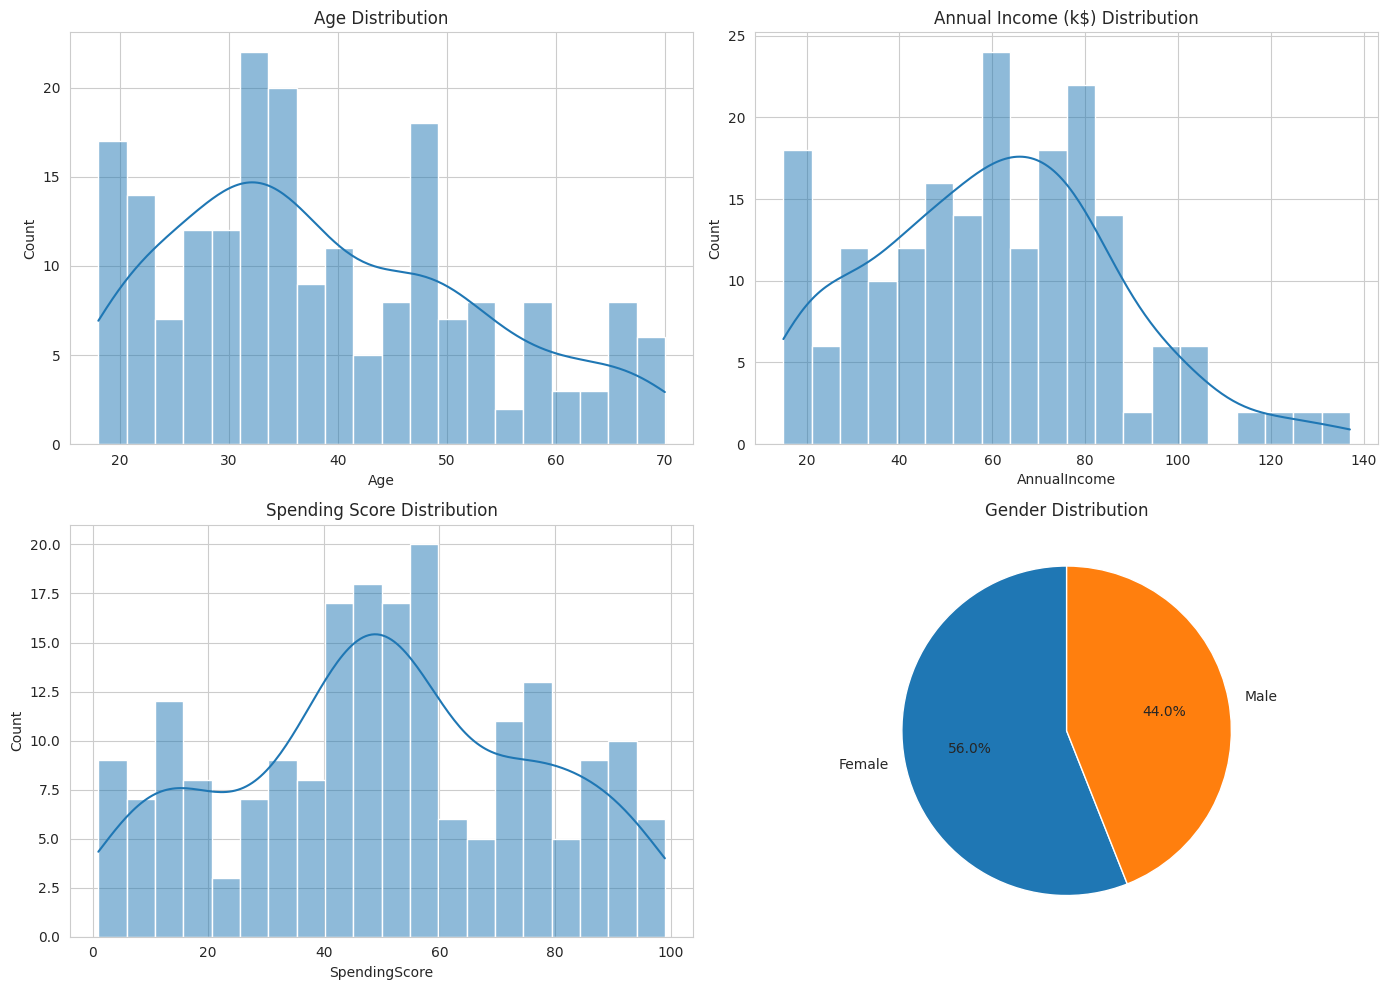

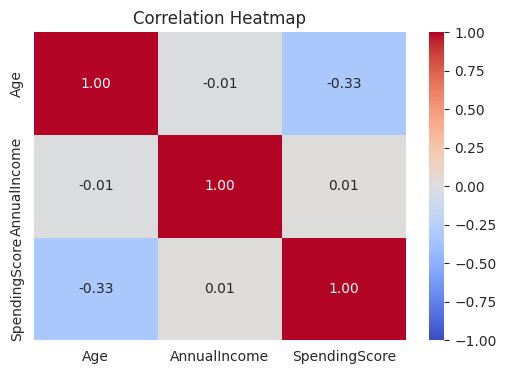

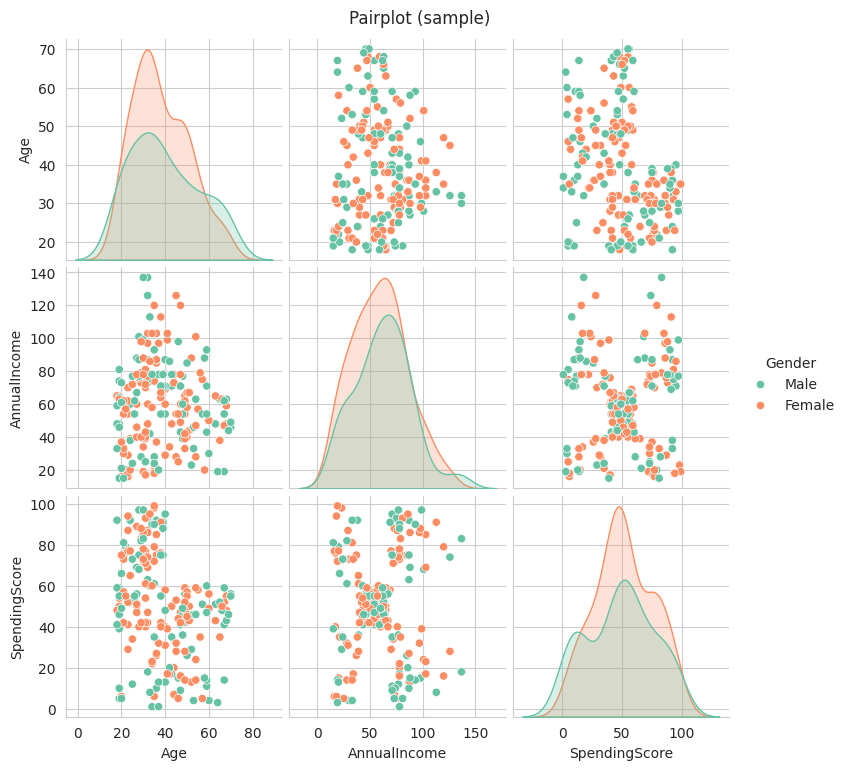

In [4]:
# Summary statistics
display(df.describe(include='all').T)

# Numerical summary
display(df[['Age','AnnualIncome','SpendingScore']].describe().T)

# Histograms and KDE plots
fig, axes = plt.subplots(2,2, figsize=(14,10))
sns.histplot(df['Age'], bins=20, kde=True, ax=axes[0,0]).set_title('Age Distribution')
sns.histplot(df['AnnualIncome'], bins=20, kde=True, ax=axes[0,1]).set_title('Annual Income (k$) Distribution')
sns.histplot(df['SpendingScore'], bins=20, kde=True, ax=axes[1,0]).set_title('Spending Score Distribution')

# Gender pie (safe)
if 'Gender' in df.columns:
    gender_counts = df['Gender'].fillna('Unknown').value_counts()
    axes[1,1].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
    axes[1,1].set_title('Gender Distribution')
else:
    axes[1,1].text(0.5, 0.5, 'Gender column not found', ha='center', va='center')
    axes[1,1].set_title('Gender Distribution')

plt.tight_layout()
plt.show()

# Correlation heatmap
corr = df[['Age','AnnualIncome','SpendingScore']].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Pairplot sample for speed
sample = df.sample(n=min(300, len(df)), random_state=42)
sns.pairplot(sample[['Age','AnnualIncome','SpendingScore','Gender']].dropna(), hue='Gender', diag_kind='kde', palette='Set2')
plt.suptitle('Pairplot (sample)', y=1.02)
plt.show()

## 5) Feature Selection & Scaling
We select **Annual Income** and **Spending Score** for clustering and scale them using `StandardScaler`.


In [5]:
# Select features for clustering
X = df[['AnnualIncome','SpendingScore']].values
print('Feature sample (first 5 rows):')
print(X[:5])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print('\nScaled feature sample (first 5 rows):')
print(X_scaled[:5])

Feature sample (first 5 rows):
[[15 39]
 [15 81]
 [16  6]
 [16 77]
 [17 40]]

Scaled feature sample (first 5 rows):
[[-1.73899919 -0.43480148]
 [-1.73899919  1.19570407]
 [-1.70082976 -1.71591298]
 [-1.70082976  1.04041783]
 [-1.66266033 -0.39597992]]


## 6) Determine Optimal Number of Clusters
We use the Elbow Method (WCSS/inertia) and the Silhouette Score to evaluate k in range 2..10. We'll plot both and suggest a `k` based on the silhouette peak.


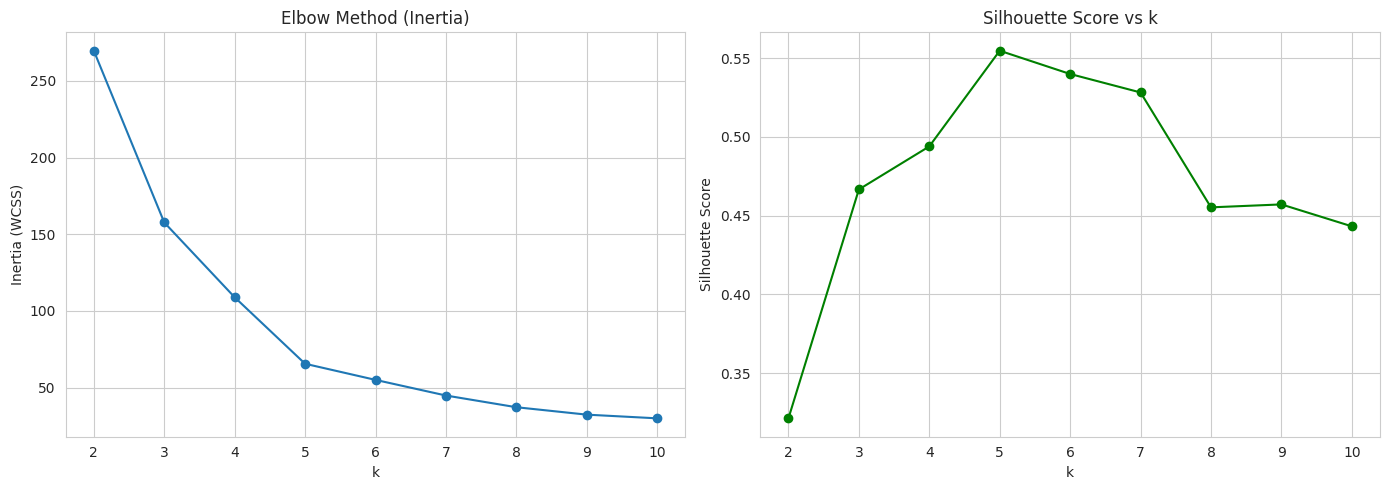

,k,inertia,silhouette
0,2,269.69,0.321
1,3,157.70,0.467
2,4,108.92,0.494
3,5,65.57,0.555
4,6,55.06,0.540
5,7,44.86,0.528
6,8,37.23,0.455
7,9,32.39,0.457
8,10,29.98,0.443


Suggested k (max silhouette): 5

Note: inspect the Elbow and Silhouette plots and choose k accordingly. You can set k_chosen to the suggested value or pick another based on the Elbow plot.


In [6]:
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

inertia = []
sil_scores = []
K_range = range(2,11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot both metrics
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].plot(list(K_range), inertia, marker='o')
ax[0].set_title('Elbow Method (Inertia)')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Inertia (WCSS)')

ax[1].plot(list(K_range), sil_scores, marker='o', color='green')
ax[1].set_title('Silhouette Score vs k')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

results_df = pd.DataFrame({'k':list(K_range), 'inertia':inertia, 'silhouette':sil_scores})
display(results_df.style.format({'inertia':'{:.2f}','silhouette':'{:.3f}'}))

# Suggest k: the k that maximizes silhouette score
suggested_k = results_df.loc[results_df['silhouette'].idxmax(),'k']
print(f"Suggested k (max silhouette): {suggested_k}")

print('\nNote: inspect the Elbow and Silhouette plots and choose k accordingly. You can set k_chosen to the suggested value or pick another based on the Elbow plot.')

## 7) K-Means Clustering
Train a K-Means model with the chosen number of clusters. By default, we use the silhouette-suggested `k` but you can change `k_chosen` manually after inspection.


In [7]:
# Choose k (default to suggested_k from previous cell)
k_chosen = int(suggested_k) if 'suggested_k' in globals() else 5
print('Using k_chosen =', k_chosen)

kmeans = KMeans(n_clusters=k_chosen, random_state=42, n_init=10)
df['Cluster_KMeans'] = kmeans.fit_predict(X_scaled)

# Compute cluster centers in original scale for interpretation
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(cluster_centers, columns=['AnnualIncome','SpendingScore']).round(2)
centers_df.index.name = 'Cluster'
display(centers_df)

# Add cluster counts
print('\nCluster counts:')
display(df['Cluster_KMeans'].value_counts().sort_index().rename('count').to_frame())

Using k_chosen = 5


,AnnualIncome,SpendingScore
Cluster,,
0,55.30,49.52
1,86.54,82.13
2,25.73,79.36
3,88.20,17.11
4,26.30,20.91



Cluster counts:


,count
Cluster_KMeans,
0,81
1,39
2,22
3,35
4,23


## 8) Visualization — 2D Scatter Plot
Plot the clusters on Annual Income vs Spending Score with discrete legend and cluster centroids.


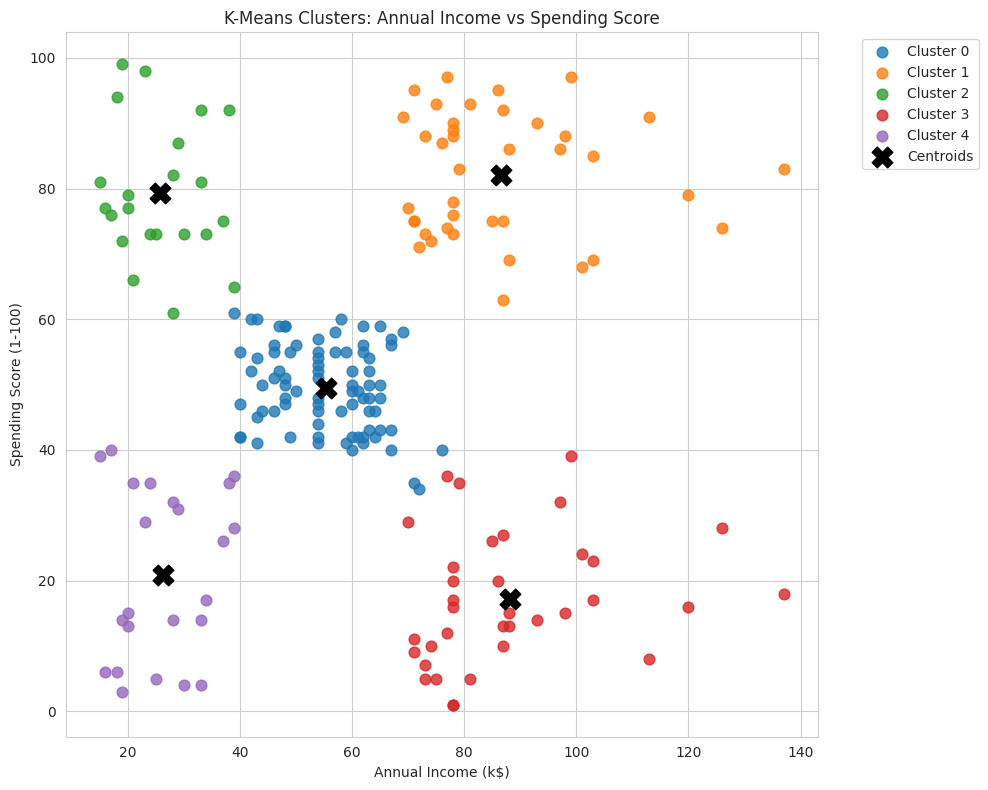

In [8]:
# 2D scatter plot with categorical legend
plt.figure(figsize=(10,8))
unique_clusters = sorted(df['Cluster_KMeans'].unique())
palette = sns.color_palette('tab10', n_colors=max(len(unique_clusters), 3))

for i, cl in enumerate(unique_clusters):
    subset = df[df['Cluster_KMeans'] == cl]
    plt.scatter(subset['AnnualIncome'], subset['SpendingScore'], s=60, alpha=0.8, label=f'Cluster {cl}', color=palette[i%len(palette)])

# Plot centroids
plt.scatter(centers_df['AnnualIncome'], centers_df['SpendingScore'], marker='X', s=220, c='black', label='Centroids')

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('K-Means Clusters: Annual Income vs Spending Score')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

## 9) Evaluation & Analysis
Show number of customers in each cluster and analyze cluster characteristics (average income & spending score per cluster).


In [9]:
# Number of customers per cluster
counts = df['Cluster_KMeans'].value_counts().sort_index()
display(counts.rename('count').to_frame())

# Cluster characteristics
cluster_stats = df.groupby('Cluster_KMeans').agg({
    'Age':'mean',
    'AnnualIncome':'mean',
    'SpendingScore':'mean',
    'CustomerID':'count'
}).rename(columns={'CustomerID':'n_customers'}).round(2)
display(cluster_stats.sort_index())

# Sorted by income for interpretability
display(cluster_stats.sort_values(by='AnnualIncome'))

,count
Cluster_KMeans,
0,81
1,39
2,22
3,35
4,23


,Age,AnnualIncome,SpendingScore,n_customers
Cluster_KMeans,,,,
0,42.72,55.30,49.52,81
1,32.69,86.54,82.13,39
2,25.27,25.73,79.36,22
3,41.11,88.20,17.11,35
4,45.22,26.30,20.91,23


,Age,AnnualIncome,SpendingScore,n_customers
Cluster_KMeans,,,,
2,25.27,25.73,79.36,22
4,45.22,26.30,20.91,23
0,42.72,55.30,49.52,81
1,32.69,86.54,82.13,39
3,41.11,88.20,17.11,35


## 10) Bonus: Other Algorithms (DBSCAN & Agglomerative) and 3D Visualization
We compute a k-distance plot to help choose DBSCAN `eps`, run DBSCAN and Agglomerative clustering, then show an interactive 3D scatter (Income, Spending Score, Age).


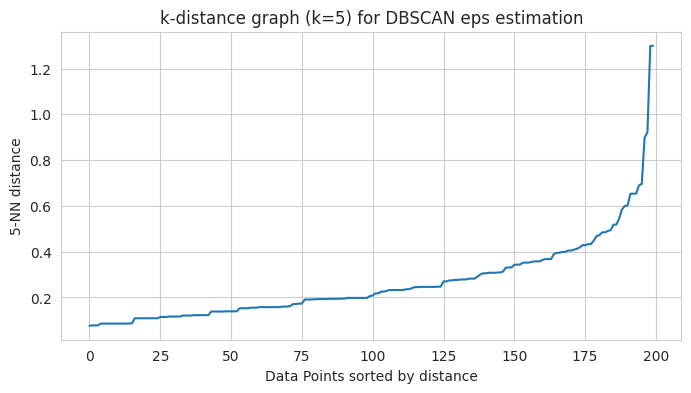

DBSCAN found 3 clusters and 8 noise points (eps=0.5)
Agglomerative cluster counts:


,count
Cluster_Agglomerative,
2,85
1,39
0,32
4,23
3,21



Silhouette scores:
K-Means: 0.5547
Agglomerative: 0.5538
DBSCAN: 0.35044619989666004


In [10]:
# DBSCAN k-distance plot
neighbors = NearestNeighbors(n_neighbors=5).fit(X_scaled)
distances, indices = neighbors.kneighbors(X_scaled)
distances = np.sort(distances[:,4], axis=0)

plt.figure(figsize=(8,4))
plt.plot(distances)
plt.xlabel('Data Points sorted by distance')
plt.ylabel('5-NN distance')
plt.title('k-distance graph (k=5) for DBSCAN eps estimation')
plt.show()

# Run DBSCAN with a chosen eps (after inspecting k-distance plot)
dbscan_eps = 0.5
db = DBSCAN(eps=dbscan_eps, min_samples=5)
df['Cluster_DBSCAN'] = db.fit_predict(X_scaled)
n_clusters_dbscan = len(set(df['Cluster_DBSCAN'])) - (1 if -1 in df['Cluster_DBSCAN'] else 0)
n_noise = list(df['Cluster_DBSCAN']).count(-1)
print(f'DBSCAN found {n_clusters_dbscan} clusters and {n_noise} noise points (eps={dbscan_eps})')

# Agglomerative clustering (same number of clusters as k_chosen for comparison)
agg = AgglomerativeClustering(n_clusters=k_chosen)
df['Cluster_Agglomerative'] = agg.fit_predict(X_scaled)
print('Agglomerative cluster counts:')
display(df['Cluster_Agglomerative'].value_counts().rename('count').to_frame())

# Silhouette comparison (guard where needed)
kmeans_sil = silhouette_score(X_scaled, df['Cluster_KMeans'])
agg_sil = silhouette_score(X_scaled, df['Cluster_Agglomerative'])
db_sil = silhouette_score(X_scaled, df['Cluster_DBSCAN']) if n_clusters_dbscan > 1 else None

print('\nSilhouette scores:')
print(f'K-Means: {kmeans_sil:.4f}')
print(f'Agglomerative: {agg_sil:.4f}')
print(f'DBSCAN: {db_sil if db_sil is not None else "N/A (<=1 cluster)"}')

In [11]:
# 3D interactive scatter with Plotly (Income, SpendingScore, Age)
fig = px.scatter_3d(df, x='AnnualIncome', y='SpendingScore', z='Age', color='Cluster_KMeans',
                    hover_data=['CustomerID','Gender'], title='3D: Income vs SpendingScore vs Age (KMeans clusters)')
fig.update_layout(scene=dict(xaxis_title='Income (k$)', yaxis_title='Spending Score', zaxis_title='Age'))
fig.show()

## 11) Conclusion
- We cleaned and explored the Mall Customer dataset, selecting Annual Income and Spending Score for clustering.
- We used the Elbow method and Silhouette score to guide selection of `k`, then trained a K-Means model and visualized segments.
- We provided cluster summaries (counts & average characteristics) and compared alternatives (DBSCAN & Agglomerative).

---
*This notebook is ready to run in Google Colab. Upload `Mall_Customers.csv` and run all cells top-to-bottom.*